## DEL-07 Programming Exercise - Parameter Initialization
### (created by Prof. Dr.-Ing. Christian Bergler & Prof. Dr. Fabian Brunner)

Documentation: **Python-Bibliothek Pandas** - https://pandas.pydata.org/docs/

Documentation: **Numpy** - https://numpy.org/doc/

Documentation: **Sklearn** - https://scikit-learn.org/stable/index.html

Documentation: **Matplotlib** - Documentation: https://matplotlib.org/stable/index.html

Documentation: **Matplotlib** - Graphics Gallery: https://matplotlib.org/2.0.2/gallery.html

Additional Documentation: **Python Tutorial** - https://docs.python.org/3/tutorial/

Additional Documentation: **Matthes Eric, "Python crash course: A hands-on, project-based introduction to programming"**, ISBN: 978-1-59327-603-4, ©2023 no starch press  

### Task DEL-07-1 (Xavier-Initialization)

a) Modify the class `MLP` developed in previous exercises so that the hyperbolic tangent is used as the activation function in the hidden layers (previously: `sigmoid`)

b) Now use the MLP class to train an `MLP` with 10 hidden layers consisting of 5 nodes each on the Iris dataset. Test the following strategies for initializing the parameters one after the other:
* Initializing all parameters (weight matrices and bias vectors) with zero
* Initialize the bias vectors with zero and the weight matrices with equally distributed values from the interval $(-0.01, 0.01)$
* Initialization of the bias vectors with zero and the weight matrices with equally distributed values according to Xavier

First select a suitable learning rate. Visualize the development of the error function over the course of the training (loss history). Explain your observations.
  
<b>Remark:</b> a model with so many parameters is not necessary/useful for a data set of such a small size. In this task, only the effects of the different initializations are to be demonstrated.

In [3]:
import pandas as pd
import numpy as np

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(0,x)

def softmax(O):
    O_exp = np.exp(O - np.max(O, axis=1, keepdims=True))
    partition = O_exp.sum(axis=1, keepdims=True)
    return O_exp / partition

def tanh(x):
    return np.tanh(x)
    

In [5]:
# forward
def activation(x):
    return tanh(x)
    

# backward (derivative)
def d_activation(x):
    return 1 - (tanh(x) ** 2)
    

#### Different Initialization Techniques

- Make use of the `random.uniform` and `random.normal` functions and return a initialized weight matrix of size `n_in x n_out`
- See also the Table with all the different activation functions and weight initializations for uniform and normal distributions as part of the lecture slides

In [6]:
def constant(n_in, n_out, alpha=0):
    return alpha*np.ones((n_in, n_out))

def uniform(n_in, n_out, alpha=1):
    return np.random.uniform(-alpha, alpha, size=(n_in, n_out))

def xavier_uniform(n_in, n_out):
    limit = np.sqrt(6 / (n_in + n_out))
    return np.random.uniform(-limit, limit, size=(n_in, n_out))

def xavier_normal(n_in, n_out):
    stddev = np.sqrt(2 / (n_in + n_out))
    return np.random.normal(0, stddev, size=(n_in, n_out))

def he_uniform(n_in, n_out):
    limit = np.sqrt(6 / n_in)
    return np.random.uniform(-limit, limit, size=(n_in, n_out))

def he_normal(n_in, n_out):
    stddev = np.sqrt(2 / n_in)
    return np.random.normal(0, stddev, size=(n_in, n_out))

#### Multi-Layer Perceptron Class

- Try all the different initialization techniques within the `initialize_weights` function and interpret as well as evaluate the model performance (initialize bias with 0)
- Call the `activation` function as part of the forward propagation

In [88]:
class MLP:
    def __init__(self, nodes_per_layer, lr=1.0, num_iter = 100):
        self.learning_rate = lr
        self.num_iter = num_iter
        self.n_layers = len(nodes_per_layer) #number of layers
        self.nodes_per_layer = nodes_per_layer #list containing the number of nodes for each layer
        self.n_classes = nodes_per_layer[-1] #number of output units (=number of classes for classification)
        self.weight_matrices = [] #in this list, the weight matrices will be stored
        self.bias_vectors = [] #in this list, the bias vectors will be stored
        
        
   
    def initialize_weights(self):
        """
        When this function is called, the weight matrices and bias vectors are 
        initialized with random normally distributed numbers and stored in the instance parameters weight_matrices and bias_vectors
        For each layer (except the input layer), one weight matrix and one bias vector is needed.
        The dimensions of the matrices depend on the number of units of the layers.
        """ 
        for i in range(self.n_layers - 1):
            n_in = self.nodes_per_layer[i]
            n_out = self.nodes_per_layer[i + 1]
            W = uniform(n_in, n_out)
            b = np.zeros((1, n_out))
            self.weight_matrices.append(W)
            self.bias_vectors.append(b)
    
    def net(self, X):
        """
        model function to perform the forward pass through the net for all samples in the batch X
        
        In each layer except the output layer, sigmoid activation is used. 
        In the output layer, softmax activation is used.
        
        :param X: batch of training data of dimension n_samples x n_features
        :type X: numpy array
        :return: array containing the predicted scores for all samples of the batch X (dimension: n_samples x n_classes)
        :rtype: numpy array
        """ 
        layer_outputs = []
        layer_inputs = []
        H = X

        layer_outputs.append(H)
        for (W, b) in zip(self.weight_matrices[:-1], self.bias_vectors[:-1]):
            Z = H@W+b

            H = sigmoid(Z)
            
            layer_outputs.append(H)
            layer_inputs.append(Z)
            
        Z = H@self.weight_matrices[-1]+self.bias_vectors[-1]
        H = softmax(Z)
        
        layer_outputs.append(H)
        layer_inputs.append(Z)
        
        self.layer_outputs = layer_outputs
        self.layer_inputs = layer_inputs

        return H
    

    def fit(self, X, y):
        """
        Model training using gradient descent optimization algorithm

        :param X: batch of training data of dimension n_samples x n_features
        :type X: numpy array
        :param y: target values corresponding to records in X 
        :type y: numpy array
        :return: List containing the values of the loss function after each iteration of Gradient descent
        :rtype: list
        """
        
        loss_history = []
        for it in range(self.num_iter):
                Yhat = self.net(X)
                Y = np.eye(self.n_classes)[y]
                l = -np.sum(np.log(np.sum(Y * Yhat, axis=1))) / X.shape[0]
                loss_history.append(l)
                
                deltas = []
                deltas.append(Yhat - Y)
                
                L = self.n_layers
                for l in range(L-2, 0, -1):
                    deltas.append(deltas[-1]@self.weight_matrices[l].T*d_activation(self.layer_inputs[l-1]))
                deltas = deltas[::-1]
                
                dW = []
                db = []
                for l in range(L-1):
                    dW.append(self.layer_outputs[l].T@deltas[l]) #beachte Indizes: in der Formel verschoben, aber es gibt für die Eingabeschicht auch eine Aktivierung, daher ist der Index nur anscheinlich verschoben
                    db.append(deltas[l].sum(axis=0, keepdims=True))

                for l in range(L-1):
                    self.weight_matrices[l] -= self.learning_rate/X.shape[0]*dW[l]
                    self.bias_vectors[l] -= self.learning_rate/X.shape[0]*db[l]
                    
        return loss_history      
                    
    def predict(self, X):
        """
        Predict classes based on the largest predicted class probability
        
        :param X: batch of data to be scored
        :type X: numpy array
        :return: predicted classes for the records in X
        :rtype: numpy array
        """
        Yhat = self.net(X)
        return np.argmax(Yhat, axis=1)

#### DEL-07-2 (Model Training - Classifier for the Iris Data Corpus)

In [89]:
from sklearn import datasets

iris = datasets.load_iris()
X = np.array(iris.data, dtype='float32') 
Y = np.array(iris.target)

In [90]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

- Create a list of layers, including an input layer with size 4, 10 hidden layers of size 5 each, and an output layer with size 3

In [91]:
# Define the sizes of the layers
input_layer_size = 4
hidden_layer_size = 5
num_hidden_layers = 10
output_layer_size = 3

# Create the list of layers
layers = [input_layer_size] + [hidden_layer_size] * num_hidden_layers + [output_layer_size]


- Create MLP, initialize weights, train and save the learning progress in a variable `loss_history`, and predict

In [92]:
mlp = MLP(layers)
mlp.initialize_weights()

In [93]:
loss_history = mlp.fit(X, Y)

In [94]:
predictions = mlp.predict(X)

- Visualization of the `loss_history` in a line plot

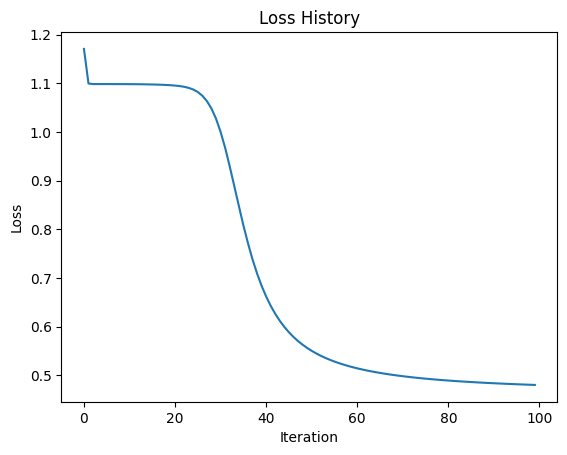

In [95]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History')
plt.show()